In [18]:
%reload_ext autoreload
%autoreload 2

In [19]:
import itertools as it
from path import Path
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import pyBigWig
from scibelt.pre_process import HDTM_Runs
from IPython.display import display, Image
from ipywidgets import interact
from collections import defaultdict

%matplotlib inline

In [3]:
pl.rcParams["axes.grid"] = True
pl.rcParams["grid.linestyle"] = "--"
pl.rcParams["font.family"] = "serif"
pl.rcParams["figure.max_open_warning"] = 50

In [4]:
INPUTS_DIR = Path("../data/inputs/")
INTERIM_DIR = Path("../data/interim/")
OUTPUTS_DIR = Path("../data/outputs/")
FIG_DIR = Path("../figures/")
(FIG_DIR / "by_reads").makedirs_p();
(FIG_DIR / "by_chrom").makedirs_p();

In [5]:
runs = HDTM_Runs("../data/inputs/runs.csv", "../data/inputs/reads/")

In [7]:
def extract_chroms(bw_file):
    with pyBigWig.open(bw_file) as bw:
        return bw.chroms()

def clamp_range(start, end, l):
    start, end = map(int, (start, end))
    if start < 0:
        start = 0
    if end < 0:
        end = l + end
    if end > l:
        end = l - 1
    return start, end

def extract_scores(bw_file, chrom, *, x_range=None, bins=200):
    if x_range is None:
        x_range = (0, -1)
    with pyBigWig.open(bw_file) as bw:
        l = bw.chroms(chrom)
    start, end = clamp_range(*x_range, l)
    chunksize = (end - start) // bins
    chunks = np.arange(start, end - chunksize, chunksize)
    with pyBigWig.open(bw_file) as bw:
        scores = np.array([bw.stats(chrom, i, i + chunksize)[0] for i in chunks]).astype(float)
    return chunks, scores, chunksize

In [8]:
chroms_map = defaultdict(list)
for sample_name, row in runs.samples.iterrows():
    bw_file = OUTPUTS_DIR / f"{row.reads_name}.bw"
    chroms = extract_chroms(bw_file)
    for chrom in chroms:
        chroms_map[chrom].append(row.name)

RuntimeError: Received an error during file opening!

In [9]:
def plot_scores_by_reads(bw_file):
    chroms = extract_chroms(bw_file)
    sns.set_context("paper")

    fig, axs = pl.subplots(len(chroms), 1, figsize=(6, 3 * len(chroms)), constrained_layout=True, squeeze=False)
    for ax, chrom in zip(axs.flatten(), chroms):
        chunks, scores, chunksize = extract_scores(bw_file, chrom, bins=200)
        ax.bar(chunks / 1000, scores, chunksize / 1000, color="black")
        ax.margins(0)
        ax.set_title(f"Chromosome: {chrom}")
        ax.set_ylabel("normalized score")
        ax.set_xlabel("position (kbp)")
    return fig

## Plot data per reads

In [9]:
for sample_name, row in runs.samples.iterrows():
    bw_file = OUTPUTS_DIR / f"{row.reads_name}.bw"
    fig = plot_scores_by_reads(bw_file)
    fig.suptitle(row.reads_name)
    fig.savefig(FIG_DIR / "by_reads" / f"{row.reads_name}.png")
    pl.close(fig)

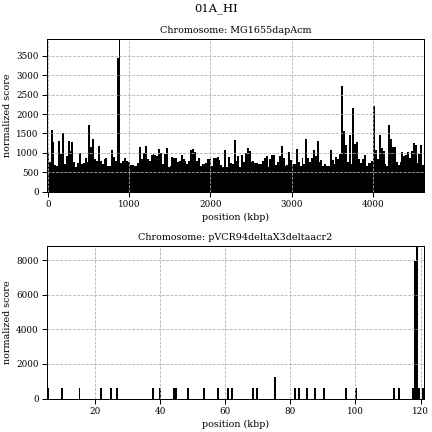

In [10]:
@interact
def display_plot(sample_name=runs.samples.index):
    display(Image(FIG_DIR / "by_reads" / f"{runs[sample_name].reads_name}.png"))

## Plot data per chromosome

In [11]:
def plot_scores_by_chroms(chrom, sample_names):
    
    sns.set_context("paper")

    fig, axs = pl.subplots(len(sample_names), 1, figsize=(6, 3 * len(sample_names)), constrained_layout=True, squeeze=False)
    for ax, sample_name in zip(axs.flatten(), sample_names):
        sample = runs[sample_name]
        bw_file = OUTPUTS_DIR / f"{sample.reads_name}.bw"
        chunks, scores, chunksize = extract_scores(bw_file, chrom, bins=200)
        ax.bar(chunks / 1000, scores, chunksize / 1000, color="black")
        ax.margins(0)
        ax.set_title(f"Sample: {sample_name}")
        ax.set_ylabel("normalized score")
        ax.set_xlabel("position (kbp)")
    return fig

In [12]:
for chrom, sample_names in chroms_map.items():
    fig = plot_scores_by_chroms(chrom, sample_names)
    fig.suptitle(chrom)
    fig.savefig(FIG_DIR / "by_chrom" / f"{chrom}.png")
    pl.close(fig)

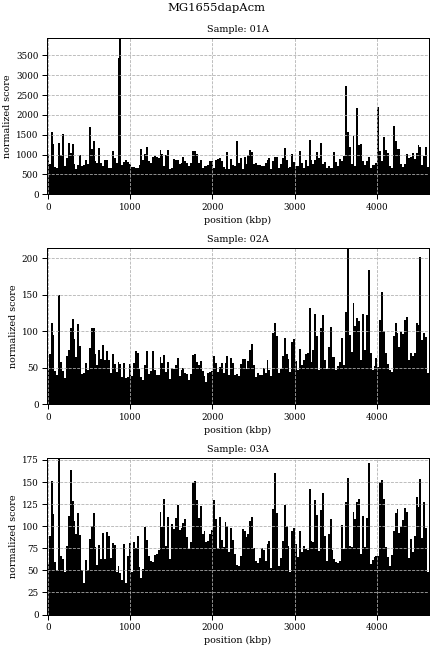

In [13]:
@interact
def display_plot(chrom=chroms_map.keys()):
    display(Image(FIG_DIR / "by_chrom" / f"{chrom}.png"))

## Custom plot for publication

Text(0.5, 0, 'position (kbp)')

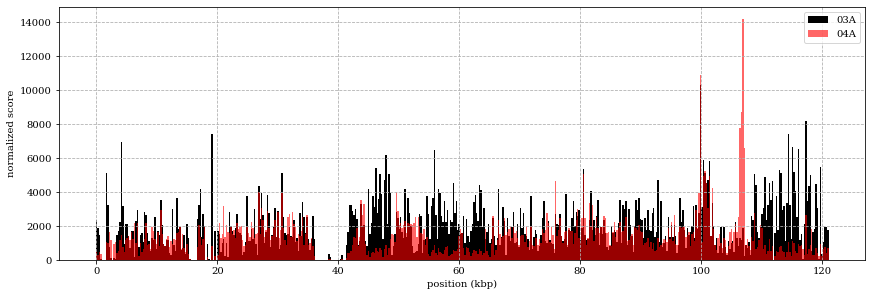

In [23]:
chrom = "pVCR94deltaX3deltaacr2"


fig, ax = pl.subplots(constrained_layout=True, figsize=(12, 4))

sample = runs["03A"]
bw_file = OUTPUTS_DIR / f"{sample.reads_name}.bw"
chunks, scores, chunksize = extract_scores(bw_file, chrom, bins=500)
ax.bar(chunks / 1000, scores, chunksize / 1000, color="black", label=sample.name)

sample = runs["04A"]
bw_file = OUTPUTS_DIR / f"{sample.reads_name}.bw"
chunks, scores, chunksize = extract_scores(bw_file, chrom, bins=500)
ax.bar(chunks / 1000, scores, chunksize / 1000, color="red", label=sample.name, alpha=.6)

ax.legend()
ax.set_ylabel("normalized score")
ax.set_xlabel("position (kbp)")